# W11 - Class Assignment

Evelin Alim Natadjaja / 0706022310021

## Import Libraries

In [179]:
!pip install kneed

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

## Data Pre-processing

In [181]:
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/COVID-19%20Coronavirus%20(2).csv"
df = pd.read_csv(url)
df.head()

,Country,Other names,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
0,Afghanistan,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743
1,Albania,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058
2,Algeria,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216
3,Andorra,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271
4,Angola,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438


In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  225 non-null    object 
 1   Other names              224 non-null    object 
 2   ISO 3166-1 alpha-3 CODE  225 non-null    object 
 3   Population               225 non-null    int64  
 4   Continent                225 non-null    object 
 5   Total Cases              225 non-null    int64  
 6   Total Deaths             225 non-null    int64  
 7   Tot Cases//1M pop        225 non-null    int64  
 8   Tot Deaths/1M pop        225 non-null    int64  
 9   Death percentage         225 non-null    float64
dtypes: float64(1), int64(5), object(4)
memory usage: 17.7+ KB


In [183]:
df.describe()

,Population,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage
count,2.250000e+02,2.250000e+02,2.250000e+02,225.000000,225.000000,225.000000
mean,3.507321e+07,2.184781e+06,2.744813e+04,136900.373333,1096.715556,1.444125
std,1.392418e+08,7.275938e+06,9.689177e+04,145060.340289,1195.715543,1.741728
min,8.050000e+02,1.000000e+00,0.000000e+00,9.000000,0.000000,0.000000
25%,5.665570e+05,2.407100e+04,1.890000e+02,11384.000000,123.000000,0.511291
50%,5.827911e+06,1.639360e+05,1.965000e+03,88987.000000,708.000000,1.036905
75%,2.190585e+07,1.092547e+06,1.366000e+04,223335.000000,1795.000000,1.977017
max,1.439324e+09,8.183905e+07,1.008222e+06,696044.000000,6286.000000,18.151787


In [184]:
print("Missing Values:\n", df.isnull().sum())
print("Duplicates:", df.duplicated().sum())

Missing Values:
 Country                    0
Other names                1
ISO 3166-1 alpha-3 CODE    0
Population                 0
Continent                  0
Total Cases                0
Total Deaths               0
Tot Cases//1M pop          0
Tot Deaths/1M pop          0
Death percentage           0
dtype: int64
Duplicates: 0


In [185]:
#Drop column other names because it's not relevant
df.drop(columns=['Other names'], inplace=True)

## Exploratory Data Analysis

In [186]:
import plotly.express as px
fig = px.choropleth(df, locations="ISO 3166-1 alpha-3 CODE",
                    color="Continent",
                    hover_name="Country",
                    projection="natural earth",
                    title="World Map of Countries by Continent"
                    )
fig.show()

The map confirms that the dataset includes countries from all major regions of the world (Asia, Europe, Americas, Africa, Oceania), ensuring the analysis is truly global. It visualizes the distinct clusters (Continents) that will be used later for regional risk comparison.

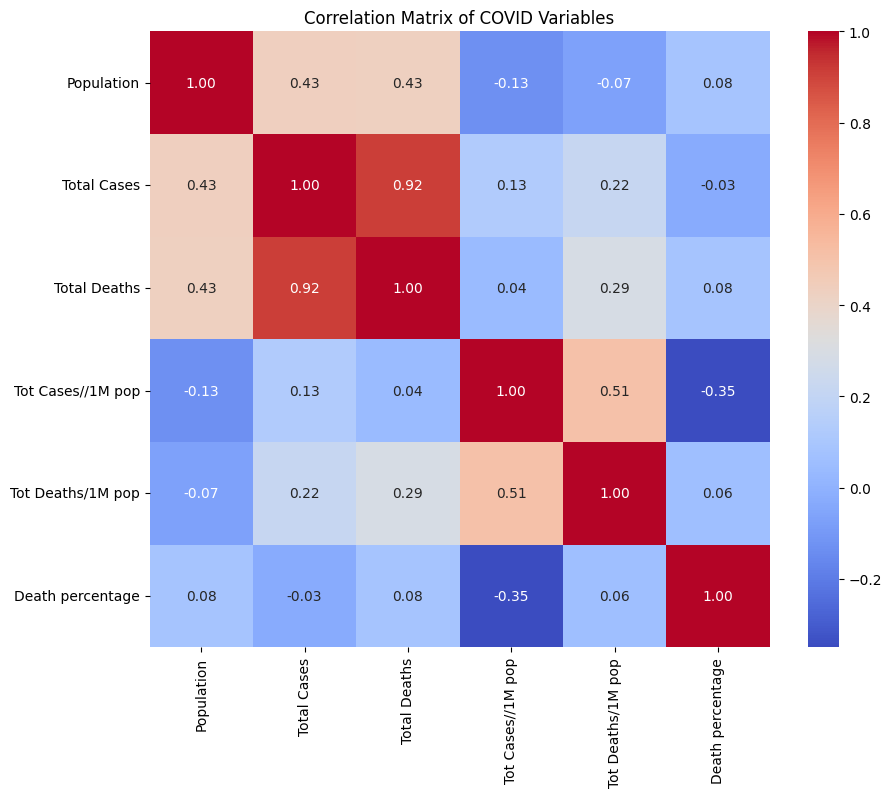

In [187]:
plt.figure(figsize=(10, 8))
corr_matrix = df[['Population', 'Total Cases', 'Total Deaths', 'Tot\xa0Cases//1M pop', 'Tot\xa0Deaths/1M pop', 'Death percentage']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of COVID Variables")
plt.show()

From the heatmap, I observe a high correlation between Total Cases and Total Deaths. However, there is a lower correlation between Population and Death Percentage, suggesting that population size alone does not determine pandemic severity.

## Encoding & Transformation

In [188]:
# Cluster based on the rates, not the raw totals
from sklearn.preprocessing import StandardScaler, LabelEncoder

features = ['Tot\xa0Cases//1M pop', 'Tot\xa0Deaths/1M pop', 'Death percentage']
X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## K-Means Clustering

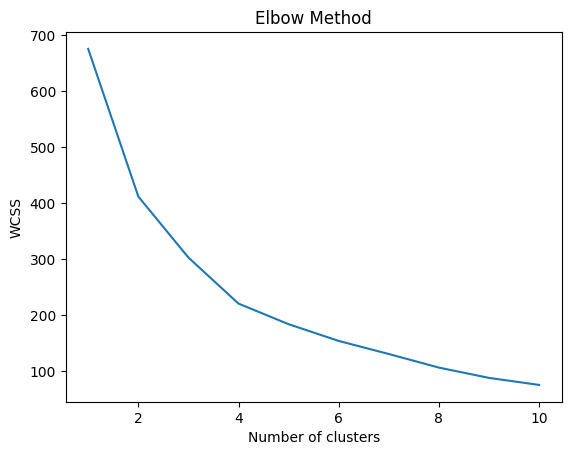

In [189]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):   #clusters 1-10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

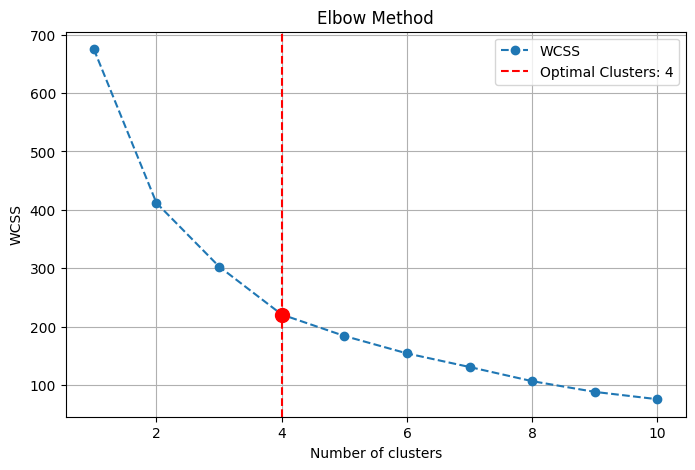

The optimal number of clusters is: 4


In [190]:
# Example WCSS values and cluster numbers
clusters = range(1, 11)

# Automatically find the elbow point using the KneeLocator
knee_locator = KneeLocator(clusters, wcss, curve="convex", direction="decreasing")
optimal_clusters = knee_locator.knee

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(clusters, wcss, marker='o', linestyle='--', label="WCSS")
plt.axvline(optimal_clusters, linestyle='--', color='red', label=f'Optimal Clusters: {optimal_clusters}')
plt.scatter(optimal_clusters, wcss[optimal_clusters-1], c='red', s=100, zorder=5)  # Highlight elbow point
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.legend()
plt.grid(True)
plt.show()

# Print the optimal number of clusters
print(f"The optimal number of clusters is: {optimal_clusters}")

In [191]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

df['KMeans Cluster'] = clusters
df.head()

,Country,ISO 3166-1 alpha-3 CODE,Population,Continent,Total Cases,Total Deaths,Tot Cases//1M pop,Tot Deaths/1M pop,Death percentage,KMeans Cluster
0,Afghanistan,AFG,40462186,Asia,177827,7671,4395,190,4.313743,0
1,Albania,ALB,2872296,Europe,273870,3492,95349,1216,1.275058,0
2,Algeria,DZA,45236699,Africa,265691,6874,5873,152,2.587216,0
3,Andorra,AND,77481,Europe,40024,153,516565,1975,0.382271,2
4,Angola,AGO,34654212,Africa,99194,1900,2862,55,1.915438,0


## Hierarchical Clustering

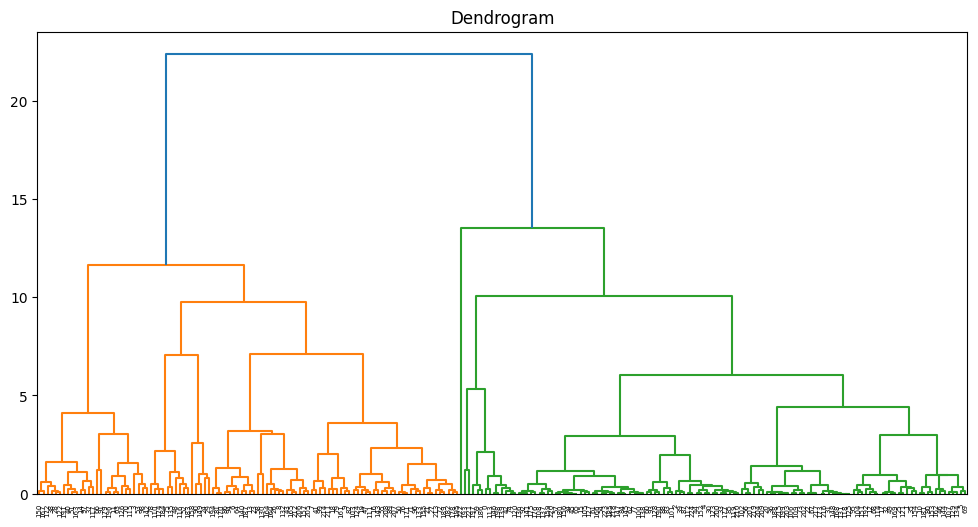

In [193]:
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title('Dendrogram')
plt.show()

In [194]:
## use the same K as K-Means for fair comparison
hc = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
df['Hierarchy Cluster'] = hc.fit_predict(X_scaled)

## Evaluation & Profiling

In [195]:
score_kmeans = silhouette_score(X_scaled, df['KMeans Cluster'])
score_hc = silhouette_score(X_scaled, df['Hierarchy Cluster'])
print(f"Silhouette Score (K-Means): {score_kmeans:.3f}")
print(f"Silhouette Score (Hierarchical): {score_hc:.3f}")

Silhouette Score (K-Means): 0.466
Silhouette Score (Hierarchical): 0.395


### KMeans model

In [196]:
summary = df.groupby('KMeans Cluster')[features].agg(['mean', 'std', 'min', 'max'])
print("\nCluster Summary (Means):")
print(summary)


Cluster Summary (Means):
               Tot Cases//1M pop                                 \
                            mean            std     min     max   
KMeans Cluster                                                    
0                   42296.664062   49918.783170       9  187113   
1                  165658.000000   93441.200583   43147  414819   
2                  323964.532258  109321.524894  161401  696044   
3                     584.666667     693.311137      16    1357   

               Tot Deaths/1M pop                          Death percentage  \
                            mean          std   min   max             mean   
KMeans Cluster                                                               
0                     378.453125   430.113625     0  1651         1.416193   
1                    3173.781250  1088.038446  1832  6286         2.341228   
2                    1557.725806   805.397696   174  3354         0.526839   
3                      59.666667    

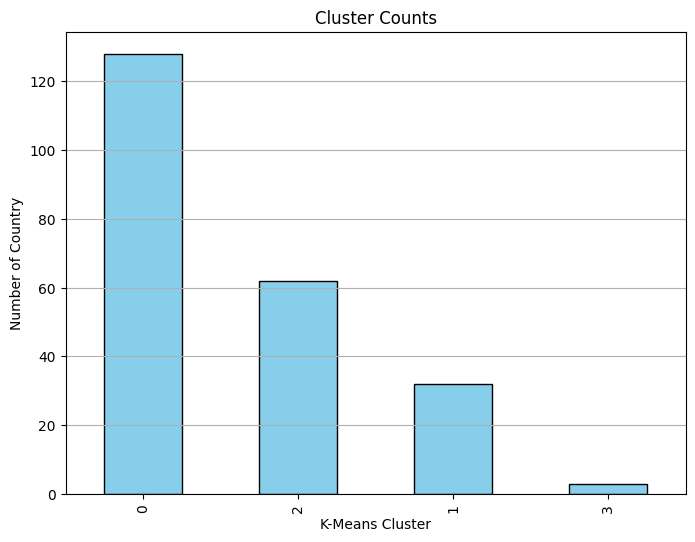

In [204]:
cluster_counts = df['KMeans Cluster'].value_counts()

plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cluster Counts')
plt.xlabel('K-Means Cluster')
plt.ylabel('Number of Country')
plt.grid(axis='y')
plt.show()

In [198]:
fig_cluster = px.choropleth(df, locations="ISO 3166-1 alpha-3 CODE",
                    color=df['KMeans Cluster'].astype(str),
                    hover_name="Country",
                    projection="natural earth",
                    title="Countries Grouped by COVID-19 Impact (K-Means)"
                    )
fig_cluster.show()

### KMeans Clustering Profiling

### **Cluster 0: "Low Spread / Moderate Control"**

* Infection Rate: Low (Mean ~42k cases/1M).
* Mortality Burden: Low (Mean ~378 deaths/1M).
* Fatality Rate: Moderate (~1.4%).

This cluster likely represents countries that either implemented strict border controls early or have isolated populations. The metrics are stable, showing neither massive spread nor catastrophic failure of the health system.

Policy Recommendation: Maintain surveillance systems to prevent outbreaks. Focus on preventative measures (vaccination campaigns) rather than emergency response, as the current status is stable.

### **Cluster 1: "Critical Severity Zone" (High Mortality)**
* Infection Rate: Moderate/High (Mean ~165k cases/1M).
* Mortality Burden: Highest of all clusters (Mean ~3,173 deaths/1M).
* Fatality Rate: High (~2.3%).

These countries are facing a crisis. While their case numbers are not the highest, their death numbers are massive. This indicates a healthcare system collapse, an aging vulnerable population, or a lack of critical care resources.

Policy Recommendation: Immediate Humanitarian Aid required. Governments must prioritize ICU capacity expansion and oxygen supply chains. Investigating why the mortality per capita is so high is critical.

## **Cluster 2: "High Transmission, High Resilience"**
* Infection Rate: Highest (Mean ~323k cases/1M).
* Mortality Burden: Moderate (~1,557 deaths/1M).
* Fatality Rate: Lowest (~0.5%).

This likely represents developed nations with high mobility but excellent healthcare and testing capacity. Because they test everyone, the denominator is large, making the Death % look very small (0.5%). They are managing the virus well despite high case loads.

Policy Recommendation: Focus on economic continuity and booster shots. Since the death rate is low, strict lockdowns may no longer be necessary; focus on managing hospital load rather than stopping every single case.

### **Cluster 3: "The Statistical Anomaly" (Likely Under-reporting)**
* Infection Rate: Extremely Low (Mean ~584 cases/1M).
* Fatality Rate: Extremely High (Mean ~12%, Max ~18%).

This data pattern is suspicious. A 12-18% death rate is medically improbable for COVID-19 unless only the dying are being tested. It is highly likely these countries have zero testing capacity for the general public, so the "Total Cases" number is artificially low.

Policy Recommendation: Urgent need for Testing Kits. The government cannot make informed decisions because the data is incomplete. International organizations must send testing supplies immediately to uncover the true scale of the spread.

### Hierarchical model

In [201]:
summary = df.groupby('Hierarchy Cluster')[features].agg(['mean', 'std', 'min', 'max'])
print("\nCluster Summary:")
print(summary)


Cluster Summary:
                  Tot Cases//1M pop                                 \
                               mean            std     min     max   
Hierarchy Cluster                                                    
0                      39512.147541   51893.838132       9  221540   
1                     204892.760000  108312.832514   43147  504232   
2                        381.000000            NaN     381     381   
3                     393139.407407   92878.081362  256341  696044   

                  Tot Deaths/1M pop                         Death percentage  \
                               mean          std  min   max             mean   
Hierarchy Cluster                                                              
0                        294.213115   325.913192    0  1216         1.504966   
1                       2412.186667  1082.011886  871  6286         1.540529   
2                         69.000000          NaN   69    69        18.151787   
3          

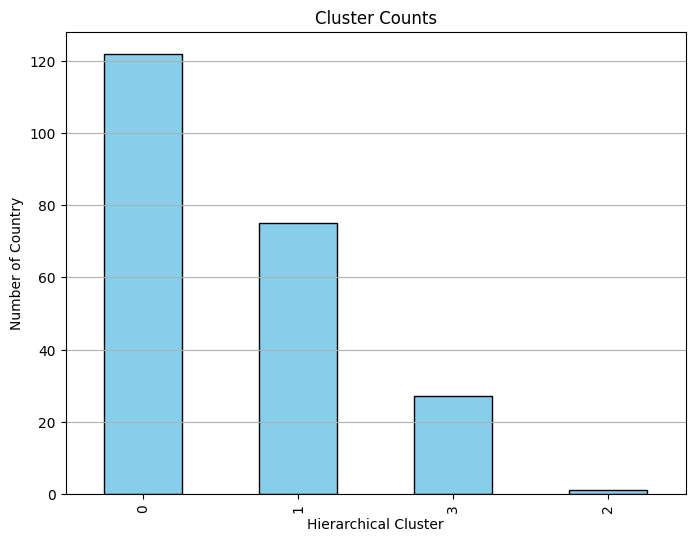

In [205]:
cluster_counts = df['Hierarchy Cluster'].value_counts()

plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cluster Counts')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('Number of Country')
plt.grid(axis='y')
plt.show()

In [206]:
fig_cluster = px.choropleth(df, locations="ISO 3166-1 alpha-3 CODE",
                    color=df['Hierarchy Cluster'].astype(str),
                    hover_name="Country",
                    projection="natural earth",
                    title="Countries Grouped by COVID-19 Impact (K-Means)"
                    )
fig_cluster.show()

Hierarchical Cluster Profiling

## **Cluster 0: "Low Spread / Low Impact" (The Majority)**
* Characteristics: Low cases (~39k/1M) and low deaths per capita.

This group represents the majority of countries where the virus is either contained, under-reported, or the population is isolated. The spread is relatively slow compared to other regions.

Policy Reccomendation: Focus on preventative surveillance and vaccination. No emergency lockdowns are needed, but border monitoring is essential to keep variants out.

## **Cluster 1: "High Mortality Zone"**
* Characteristics: High infection rates, but specifically the highest death burden per capita (Mean ~2,412 deaths/1M).

These countries are suffering the most. The healthcare systems are likely overwhelmed, or the population has high comorbidities (age, obesity, etc.). Even though cases aren't the absolute highest, people are dying at alarming rates.

Policy Recommendation: Critical Care Support. Governments must prioritize increasing ICU beds, ventilators, and oxygen supply. Immediate investigation into why treatments are failing is necessary.

## **Cluster 2: "The Extreme Outlier" (Single Country Anomaly)**
* Characteristics: Very low cases, but an extremely high Death Percentage (18.15%). The NaN standard deviation indicates this cluster likely contains only one country.

This is a statistical anomaly (likely Yemen or a similar conflict zone). It indicates a collapsed testing infrastructure where only the people already dying are being tested, driving the fatality rate artificially high.

Policy recommendation: Targeted Humanitarian Intervention. This is not a "policy" issue; it is a rescue mission. This specific country needs a dedicated UN task force to provide testing kits and basic medical infrastructure.

## **Cluster 3: "High Transmission / Low Severity"**
* Characteristics: Highest infection rate (~393k/1M) but the lowest death percentage (0.28%).

This represents wealthy, developed nations with massive testing capacity. They catch every single case, which inflates the case count but drives down the death percentage. The virus is widespread, but the healthcare system is managing it perfectly.

Policy recommendation: Maintain economic openness. The low death rate proves that vaccines and treatments are working. Shift focus from "stopping the spread" to "living with the virus."

## Conclusion

I select **K-Means** as the better model. While Hierarchical clustering successfully identified a severe outlier (Cluster 2, 18% death rate), K-Means produced more balanced clusters that grouped similar 'under-reporting' nations together, allowing for broader regional policy recommendations rather than isolating single nations.